In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

In [2]:
def replace_nan(df):
    # get a list of all the columns containing NaN
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    # compute and fill each NaN with the columns mean
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    print(np.unique(df['station']))
    print(df.shape[0] - df.dropna().shape[0])
#     print(df[df.columns[df.isnull().any()]].columns)
    print(df.isnull().any())
    print()
    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()) * num_docks  )
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy()) * num_docks
    y_gold = data["bikes"].to_numpy() * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    y_pred = np.around(y_pred)
    return y_pred


## This code is added

In [3]:
pd.options.mode.chained_assignment = None

def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    if row['hour'] > 17 or row['hour'] < 9:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    # del df["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    print(columns)
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def vectorise_dataframe(dataframe):
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    #del dataframe["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    #del dataframe["weekhour"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    #default_columns.remove('weekday')
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    #dataframe = pd.get_dummies(dataframe, columns=['weekday'])
    
    #default_columns = ["isOff", "weekday_Sunday", "weekday_Monday", "weekday_Tuesday", "weekday_Wednesday", 
                      #"weekday_Thursday", "weekday_Friday", "weekday_Saturday"] + default_columns
    
    default_columns = ["isOff"] + default_columns
    #del dataframe["weekday"]
    default_columns.remove('weekday')
    #print(default_columns)
    
    
    dataframe = dataframe[default_columns]
    
    #print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    #print(columns)
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    dataframe["numDocks"]
    
    
    
    
#     columns_kept = ["weekday", "hour", "isOff",  'full_profile_3h_diff_bikes', 
#                      'short_profile_3h_diff_bikes',  "bikes"] #'bikes_3h_ago',
    
#     for c in dataframe.columns:
#         if c not in columns_kept:
#             del dataframe[c]
    
    
    return dataframe, num_docks

df = []


for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    tmp = pd.read_csv(path)

    tmp = tmp.dropna(axis='rows')
    
    df.append(tmp)
    #print(tmp.columns)

df = pd.concat(df, ignore_index=True)

        
train, val = train_test_split(df, test_size=0.2)

train, train_docks = vectorise_dataframe(train)
val, val_docks = vectorise_dataframe(val)

scaler = RobustScaler()

train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
val[val.columns[:-1]] = scaler.transform(val[val.columns[:-1]])





In [4]:
# forest = RandomForestRegressor(n_estimators=500, n_jobs=6)
# print("initialised")
# forest.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

# importances = forest.feature_importances_
# imp_indixes = np.argsort(importances)[::-1]
# feature_order = train.columns[:-1][imp_indixes]
# importances = importances[imp_indixes]

# imp_df = pd.DataFrame(data = importances, index = feature_order, columns=["relative_importance"])

# print(score_abs_error(forest, val, val_docks))

# print(imp_df)

# Random elimination parameter tuning
## Random forest regressor

This cell uses `HalvingRandomSearchCV` to find near-optimal parameters for a random forest regressor. It takes a while to run with these parameters.

In [5]:
# from time import time
# from tqdm import tqdm
# start = time()
# print("initialised")


# #forest_boost = AdaBoostRegressor(n_estimators=400, random_state=0, learning_rate = 0.5)
# forest_random = RandomForestRegressor(n_estimators= 600, max_depth= 9)
# forest_random.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

# forest_boost = GradientBoostingRegressor(n_estimators= 20000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="squared_error", verbose = 1)#
# forest_boost.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

# print(f'fitted in {time() - start}s')

In [6]:
# y_pred = forest_boost.predict(val.iloc[:,:-1])
# print(score_abs_error(forest_boost, val, val_docks))
# y_pred = forest_random.predict(val.iloc[:,:-1])
# print(score_abs_error(forest_random, val, val_docks))

In [7]:
from time import time
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

searched_boost = GradientBoostingRegressor()

param_distributions = {"max_depth":  randint(2,6),#[2,3,4, 5, 6, None],
                       "min_samples_split": randint(2, 30),#np.around(np.linspace(2,30,5)).astype(np.int32),
                       "learning_rate": uniform(0.00001, 0.99999)#np.linspace(0.0001,1,20),
                       #"n_estimators": np.linspace(5, 5000, 5).astype(np.int32)
                      }


search = HalvingRandomSearchCV(searched_boost, param_distributions,
                               resource='n_estimators', max_resources = 5000, min_resources = 100,
                               factor = 2 ,cv = 3,     n_candidates =  50,
                               random_state=0, verbose=1, n_jobs=6).fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

print(search.cv_results_)
results_df = pd.DataFrame(search.cv_results_)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 100
max_resources_: 5000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 100
Fitting 3 folds for each of 50 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 25
n_resources: 200
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 2
n_candidates: 13
n_resources: 400
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 3
n_candidates: 7
n_resources: 800
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 4
n_candidates: 4
n_resources: 1600
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 5
n_candidates: 2
n_resources: 3200
Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0,

In [8]:
# import matplotlib.pyplot as plt

# errors = []
# rounded_errors = []
# y_pred = []
# y_gold = []

# for i in tqdm(range(len(vals))):
#     errors.append(score_abs_error(models[i], vals[i], val_docks_list[i]))
#     rounded_errors.append(score_abs_error(models[i], vals[i], val_docks_list[i], round_ = True))
    
#     pred = list(models[i].predict(vals[i].iloc[:, :-1].to_numpy()))# * val_docks_list[i])
    
#     y_pred = y_pred + pred
    
#     y_gold = y_gold + list(vals[i]["bikes"])# * val_docks_list[i])
    
# print(f'Non-rounded ensemble error: {np.mean(errors)}')
# print(f'Rounded ensemble error: {np.mean(rounded_errors)}')

# plt.hist(np.array(y_pred) - np.array(y_gold), bins=30)
# plt.show()
# plt.hist(errors, bins=30)
# plt.show()

In [9]:
# inds_best_models = np.argsort(errors)
# #print(models)
# best_model_ind = inds_best_models[0]
# best_model = models[best_model_ind]
# #print(best_model)



# best_pred = best_model.predict(val_set.iloc[:, :-1].to_numpy())# * val_set_docks
# val_gold = val_set["bikes"]# * val_set_docks

# print(f'Error on validation holdout: {mean_absolute_error(val_gold, best_pred)}')

# plt.hist(np.array(val_gold) - np.array(best_pred), bins=30)
# plt.show()

In [10]:
# model_weights = np.array(errors)
# model_weights = 1/ model_weights**(2)
# model_weights = model_weights / np.sum(model_weights)
# # should equal 1
# print(np.sum(model_weights))

# plt.hist(model_weights, bins=30)

In [11]:
# def ensemble_validation_errors(models, scalers, x, y,  docks):
#     results = np.zeros(len(models))
    
#     for i, m in enumerate(models):

#         x_i = scalers[i].transform(x)
        
#         results[i] = mean_absolute_error(m.predict(x_i),y)# * docks, y*docks)

#     return results

# print(trains[0].columns)
# print(val_set.columns)
# print(scalers[0].feature_names_in_)

# validation_errors = ensemble_validation_errors(models, scalers, val_set.iloc[:, :-1], val_set["bikes"], val_set_docks)

# model_weights = model_weights / validation_errors
# model_weights = model_weights / np.sum(model_weights)

# print(models[0].feature_importances_)


# plt.hist(model_weights, bins=30)
# plt.show()

In [12]:
# def ensemble_predict(models, scalers, model_weights, x):
#     results = np.zeros(x.shape[0])

#     for i, m in enumerate(models):

#         x_i = scalers[i].transform(x)
        
#         results = results + m.predict(x_i) * model_weights[i]

#     return results

# y_pred = ensemble_predict(models, scalers, model_weights, val_set_two.iloc[:,:-1]) #* val_set_docks_two

# val_gold_two = val_set_two["bikes"].to_numpy()# * val_set_docks_two

# print(mean_absolute_error(val_gold_two, y_pred))

# plt.hist(val_gold_two - y_pred, bins=30)



(n_estimators= 100, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.025, loss="absolute_error") = 6.171106155700234

## Score tracking

 -  vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.31, rounding integers 2.29
 
 - un-vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.33, rounding integers 2.31
 
 - vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, 2.43, 2.42
 
 - un-vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, , loss="absolute_error",  2.4, 2.38

{'learning_rate': 0.07104534783730496, 'max_depth': 3, 'min_samples_split': 22, 'n_estimators': 3200}


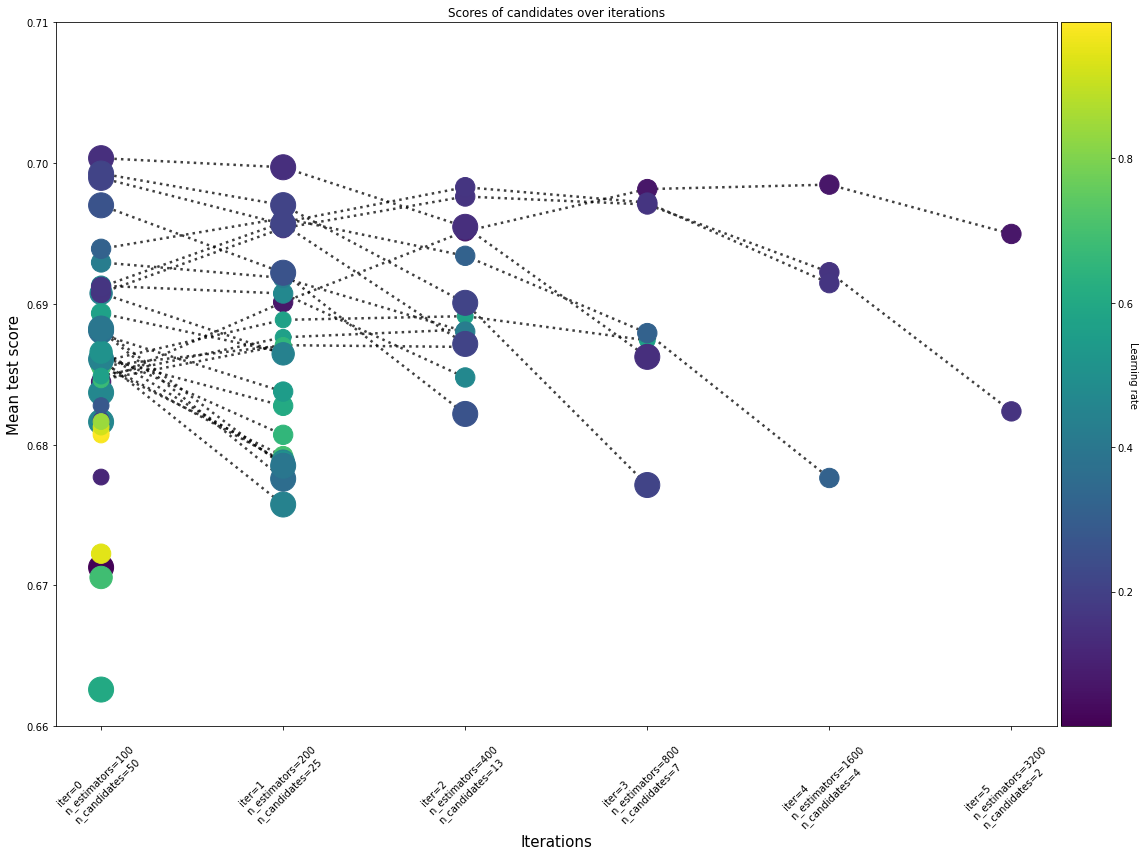

0.013581499895753713


In [87]:
print(search.best_params_)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
results = pd.DataFrame(search.cv_results_)
#print(results)
results["params_str"] = results.params.apply(str)
params = search.param_distributions
# results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
learning_rates = params["learning_rate"]
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
#print(mean_scores)
fig, ax = plt.subplots(figsize=(16,12))
#mean_scores.plot(legend=False, alpha=0.6, ax = ax, linewidth=8)

unique_learning_rates = np.unique(results["param_learning_rate"])

for i, lr in enumerate(unique_learning_rates):
    #print(results.columns)
    test_scores = results["mean_test_score"][results["param_learning_rate"] == lr].to_numpy()
    test_deviations = results["std_test_score"][results["param_learning_rate"] == lr].to_numpy()
    
    #plt.fill_between(np.arange(test_scores.shape[0]), test_scores-test_deviations, test_scores+test_deviations, alpha = 0.2)
    
    ax.plot(np.arange(test_scores.shape[0]), test_scores, linewidth = 2.5, alpha=0.75, linestyle = ':', c='0')

scat = ax.scatter(results["iter"], results["mean_test_score"], c = results["param_learning_rate"], zorder = int(1e5),
                  s = 125*results["param_max_depth"].to_numpy().astype(np.float32))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

bar = fig.colorbar(scat, cax = cax)
bar.ax.set_ylabel('Learning rate', rotation=270)


labels = [
    f"iter={i}\nn_estimators={search.n_resources_[i]} \nn_candidates={search.n_candidates_[i]}"# \nn_estimators={params["n_estimators"][i]} "
    for i in range(search.n_iterations_)
]


ax.set_ylim([0.66, 0.71])
ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()

plt.savefig("iterative_halving.png")


plt.show()

print(np.min(results["param_learning_rate"]))


In [85]:
from time import time
from tqdm import tqdm
start = time()
print("initialised")

best_params = {'learning_rate': 0.07104534783730496, 'max_depth': 3, 'min_samples_split': 22, 'n_estimators': 3200}
experimental_params = {'learning_rate': 0.07, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1600}
# #forest_boost = AdaBoostRegressor(n_estimators=400, random_state=0, learning_rate = 0.5)
# forest_random = RandomForestRegressor(n_estimators= 600, max_depth= 9)
# forest_random.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

forest_boost = GradientBoostingRegressor(**best_params, verbose = 1)#
forest_boost.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

print(f'fitted in {time() - start}s')

initialised
      Iter       Train Loss   Remaining Time 
         1           0.0935            3.28m
         2           0.0865            2.91m
         3           0.0804            2.71m
         4           0.0751            2.66m
         5           0.0704            2.63m
         6           0.0663            2.59m
         7           0.0627            2.58m
         8           0.0595            2.55m
         9           0.0567            2.54m
        10           0.0542            2.52m
        20           0.0402            2.47m
        30           0.0355            2.44m
        40           0.0336            2.42m
        50           0.0327            2.40m
        60           0.0322            2.39m
        70           0.0318            2.38m
        80           0.0316            2.38m
        90           0.0314            2.37m
       100           0.0313            2.36m
       200           0.0303            2.27m
       300           0.0295            2.1

In [89]:
y_pred = forest_boost.predict(val.iloc[:,:-1])
print(score_abs_error(forest_boost, val, val_docks))
y_pred = forest_boost.predict(val.iloc[:,:-1])
print(score_abs_error(forest_boost, val, val_docks, round_=True))

/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


2.3548835124699106


/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


2.3368544600938965


/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


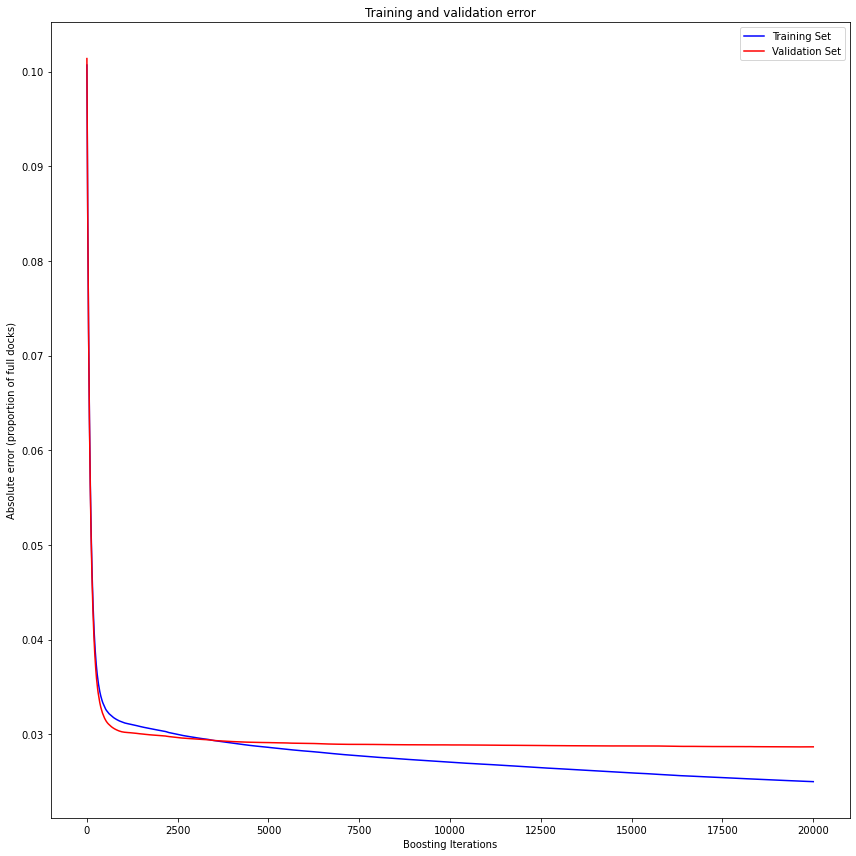

In [64]:

n_est = 20000

import matplotlib.pyplot as plt
test_score = np.zeros((n_est,), dtype=np.float64)

y_test = val["bikes"]
#y_pred = reasonable_predictions(forest_boost, val.iloc[:, :-1])

for i, y_pred in enumerate(forest_boost.staged_predict(val.iloc[:,:-1])):
    test_score[i] = forest_boost.loss_(y_test, y_pred)


fig = plt.figure(figsize=(12
                          , 12))
plt.subplot(1, 1, 1)
plt.title("Training and validation error")
plt.plot(
    np.arange(n_est) + 1,
    forest_boost.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(n_est) + 1, test_score, "r-", label="Validation Set"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Absolute error (proportion of full docks)")
#plt.yscale('log')
fig.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(y_test*val_docks - forest_boost.predict(val.iloc[:,:-1])*val_docks, bins = 30)
plt.show()

In [75]:
test = pd.read_csv('test.csv')

ids = test["Id"]

del test["Id"]
# del test["month"]
# del test["year"]

# convert_weekdays(test)
# # test[test.columns] = scaler.fit_transform(test[test.columns])

# for feature in lowest_ranked_10:
#     del test[feature]
    


test, test_docks = vectorise_dataframe(test)

print(test.columns)  
print(train.columns)

test.iloc[:, :] = scaler.transform(test)

#y_pred = forest_boost.predict(test)
y_pred = (reasonable_predictions(forest_boost, test) * test_docks).to_numpy()
print(y_pred)

sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

print(sub_df.head())

sub_df.to_csv("submission.csv")

Index(['isOff', 'numDocks', 'timestamp', 'day', 'hour', 'weekhour',
       'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades',
       'temperature.C', 'relHumidity.HR', 'airPressure.mb', 'bikes_3h_ago',
       'full_profile_3h_diff_bikes', 'full_profile_bikes',
       'short_profile_3h_diff_bikes', 'short_profile_bikes'],
      dtype='object')
Index(['isOff', 'numDocks', 'timestamp', 'day', 'hour', 'weekhour',
       'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades',
       'temperature.C', 'relHumidity.HR', 'airPressure.mb', 'bikes_3h_ago',
       'full_profile_3h_diff_bikes', 'full_profile_bikes',
       'short_profile_3h_diff_bikes', 'short_profile_bikes', 'bikes'],
      dtype='object')
[-0.  0.  0. ... 15. 15. 15.]
    bikes
Id       
1    -0.0
2     0.0
3     0.0
4     0.0
5     0.0


# Scored 4.88 on final test